# DeepFake Detection Using Transfer Learning with **EfficientNetB0**
Deepfake generation techniques have advanced significantly in recent years, making it increasingly challenging to distinguish between real and manipulated media. To address this problem, this project builds a deep learning model capable of detecting fake images using a large-scale dataset of over 140,000 images divided into training, validation, and testing splits.

In this notebook, we adopt a transfer learning approach using EfficientNetB0, a highly efficient convolutional neural network known for its strong performance-to-computational-cost ratio. EfficientNet scales depth, width, and resolution in a balanced way, allowing it to achieve high accuracy with fewer parameters compared to traditional CNNs such as VGG or ResNet.

We choose EfficientNetB0 for the following reasons:


*   High accuracy with low computational cost

*   Excellent generalization on image classification tasks

*   Strong performance on deepfake detection in prior research

*   Stable feature extraction when pretrained on ImageNet

*   Ideal for large datasets and limited GPU runtime environments


This notebook follows two training phases:


1.   Frozen Training (Feature Extraction Phase)


*   The EfficientNetB0 backbone is frozen.

*   Only the classification head is trained.

*   This stabilizes early training and prevents large weight updates.





2.   Fine-Tuning Phase


*   Selected deeper layers of EfficientNetB0 are unfrozen.

*   The learning rate is reduced.

*   The model learns more dataset-specific features and significantly improves performance.


Finally, we evaluate the model on the unseen test set and generate:


*   Performance metrics (Accuracy, Precision, Recall, F1-score)

*   Confusion matrix

*   Training curves

*   Comparison between frozen and fine-tuned stages


This end-to-end pipeline demonstrates how modern transfer learning techniques can effectively detect manipulated images at scale.

# 1. Imports and Basic Setup
This section imports all the essential Python libraries required for building the deepfake detection model.
We include:


*   TensorFlow & Keras for deep learning model construction
*   NumPy for numerical operations
*   Matplotlib for visualizing training results
*   Scikit-learn for computing evaluation metrics
*   Google Drive integration to load the dataset and save model outputs

We also configure the dataset path, create the output directory, and print the versions of TensorFlow and NumPy to ensure correct environment setup.

In [3]:
#Imports & basic setup

import os, json, glob, shutil, zipfile, itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)

from google.colab import drive
drive.mount('/content/drive')

print("TF:", tf.__version__)
print("NumPy:", np.__version__)

#Paths
DATASET_SRC = "/content/drive/MyDrive/dataset"
OUTPUT_DIR  = "/content/drive/MyDrive/deepdetect_effnet_outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Output dir:", OUTPUT_DIR)


Mounted at /content/drive
TF: 2.19.0
NumPy: 2.0.2
Output dir: /content/drive/MyDrive/deepdetect_effnet_outputs


# 2. Automatic Dataset Structure Detection
This section automatically detects the structure of the dataset and identifies the correct folders for the training, validation, and test splits.
Since large datasets may come in different directory formats (nested folders, zipped archives, unconventional naming), these helper functions:

*   Search through the dataset directory
*   Detect whether train, val, and test exist
*   Handle both regular folders and .zip files
*   Adapt to different naming patterns such as training, valid, or testing
*   Return consistent and correctly mapped split names

This ensures that the notebook can load the dataset reliably without requiring manual renaming or restructuring.

In [7]:
#Find and prepare the dataset folders (train / val / test)

def _children(d):
    return [n for n in os.listdir(d) if os.path.isdir(os.path.join(d, n))]

def _looks_like_split_root(d):
    names = [n.lower() for n in _children(d)]
    has_train = any('train' in n or 'training' in n for n in names)
    has_test  = any('test'  in n or 'testing'  in n for n in names)
    has_val   = any('val'   in n or 'valid' in n or 'validation' in n for n in names)
    return (has_train and has_test) or (has_train and has_val)

def ensure_dataset_root(src_path):
    if os.path.isdir(src_path):
        root = src_path
    elif os.path.isfile(src_path) and src_path.lower().endswith('.zip'):
        target_root = '/content/dataset_unzipped'
        if os.path.exists(target_root):
            shutil.rmtree(target_root)
        os.makedirs(target_root, exist_ok=True)

        print(f"[INFO] Unzipping: {src_path} -> {target_root}")
        with zipfile.ZipFile(src_path, 'r') as z:
            z.extractall(target_root)
        root = target_root
    else:
        raise FileNotFoundError(f"Not found or unsupported: {src_path}")

    queue, visited, depth = [root], set(), {root: 0}
    while queue:
        p = queue.pop(0)
        if p in visited or depth[p] > 3:
            continue
        visited.add(p)
        if _looks_like_split_root(p):
            return p
        for c in _children(p):
            cp = os.path.join(p, c)
            depth[cp] = depth[p] + 1
            queue.append(cp)

    for c in _children(root):
        if c.lower() == 'dataset':
            return os.path.join(root, c)

    return root

def discover_split_names(root):
    name_map = {'train': None, 'val': None, 'test': None}
    for d in _children(root):
        low = d.lower()
        if ('train' in low or 'training' in low) and name_map['train'] is None:
            name_map['train'] = d
        elif ('val' in low or 'valid' in low or 'validation' in low) and name_map['val'] is None:
            name_map['val'] = d
        elif ('test' in low or 'testing' in low) and name_map['test'] is None:
            name_map['test'] = d

    if name_map['train'] is None or name_map['test'] is None:
        raise RuntimeError(
            f"Could not detect split folders under: {root}\nFound: {_children(root)}"
        )
    return name_map

DATASET_DIR   = ensure_dataset_root(DATASET_SRC)
SPLIT_NAME_MAP = discover_split_names(DATASET_DIR)
USE_VAL_DIR    = SPLIT_NAME_MAP['val'] is not None

print("[INFO] DATASET_DIR =", DATASET_DIR)
print("[INFO] Splits map  =", SPLIT_NAME_MAP)
print("GPU:", tf.config.list_physical_devices('GPU'))


[INFO] DATASET_DIR = /content/drive/MyDrive/dataset
[INFO] Splits map  = {'train': 'train', 'val': 'val', 'test': 'test'}
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 3. Building the Training, Validation, and Test Datasets
In this section, we create the TensorFlow datasets for training, validation, and testing using image_dataset_from_directory.
We specify the target image size, batch size, number of epochs, and the number of steps per epoch to handle our large-scale dataset of deepfake images.

The build_dataset function:

*   Reads images from the detected train, val, and test folders
*   Automatically infers labels from the folder names (Fake and Real)
*   Applies shuffling for training data while keeping the test set ordered
*   Optionally performs an internal validation split if a dedicated validation folder is not provided

At the end, we print the class names to confirm that the model will be trained on two classes: Fake and Real, with more than 140,000 images in total.

In [8]:
#Build train / val / test datasets

IMG_SIZE   = (224, 224)
BATCH_SIZE = 4
SEED       = 42

EPOCHS            = 15
STEPS_PER_EPOCH  = 4000
VALIDATION_STEPS = 250

def build_dataset(split):
    real = SPLIT_NAME_MAP[split]
    split_dir = os.path.join(DATASET_DIR, real)

    if split == 'train' and not USE_VAL_DIR:
        train_dir = os.path.join(DATASET_DIR, SPLIT_NAME_MAP['train'])

        ds_train = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir,
            labels='inferred',
            label_mode='int',
            image_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            validation_split=0.15,
            subset='training',
            seed=SEED,
        )

        ds_val = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir,
            labels='inferred',
            label_mode='int',
            image_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            validation_split=0.15,
            subset='validation',
            seed=SEED,
        )
        return ds_train, ds_val

    ds = tf.keras.preprocessing.image_dataset_from_directory(
        split_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=(split != 'test'),
        seed=(SEED if split != 'test' else None),
    )
    return ds

if USE_VAL_DIR:
    train_ds = build_dataset('train')
    val_ds   = build_dataset('val')
else:
    train_ds, val_ds = build_dataset('train')

test_ds = build_dataset('test')

class_names = getattr(train_ds, 'class_names', None) or getattr(val_ds, 'class_names')
print("Classes:", class_names)


Found 140120 files belonging to 2 classes.
Found 39429 files belonging to 2 classes.
Found 10906 files belonging to 2 classes.
Classes: ['Fake', 'Real']


### Preview Dataset Samples

Before starting model training, we display a sample of images from each dataset split (training, validation, and testing).  
This helps verify that:
- Data is loaded correctly  
- Labels are mapped properly  
- Images are preprocessed correctly  

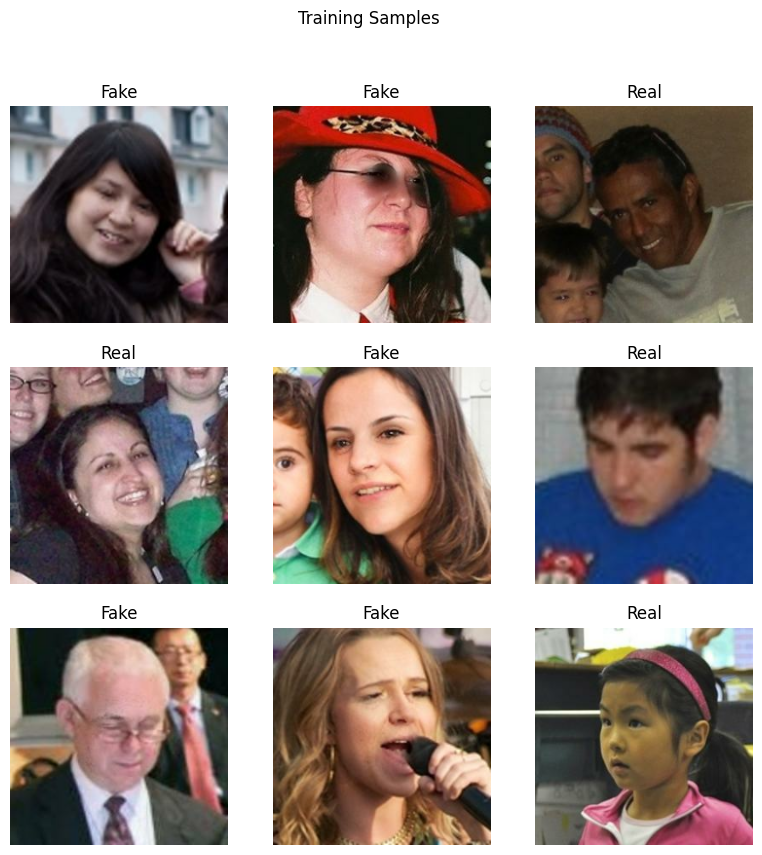

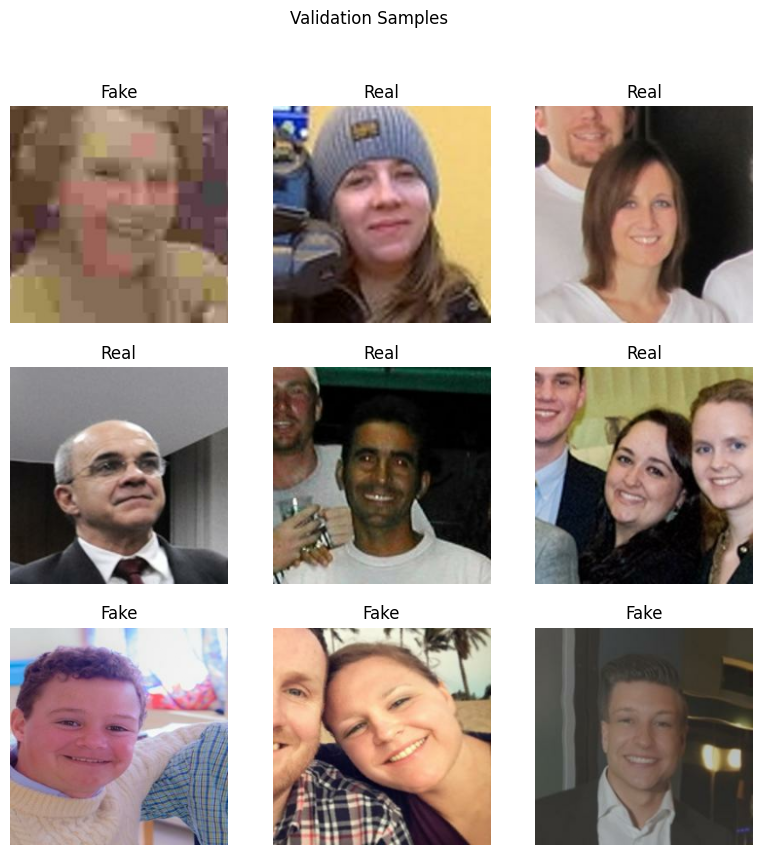

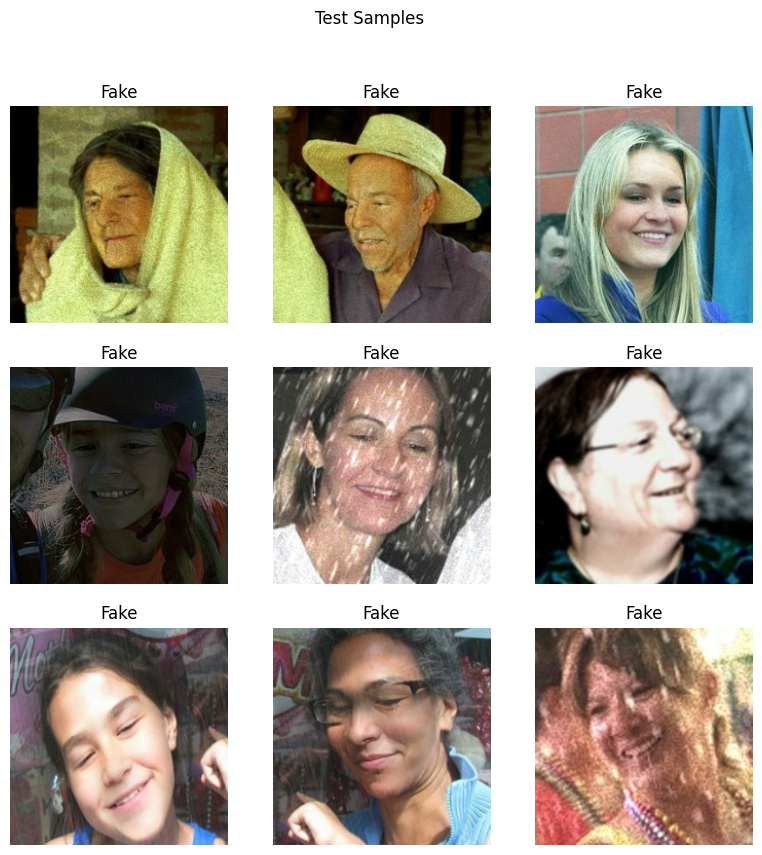

In [9]:

def _to_display_range(img):
    # (H,W,1) → (H,W)
    if img.ndim == 3 and img.shape[-1] == 1:
        img = img[..., 0]

    if img.dtype == np.uint8:
        return img

    img = img.astype(np.float32)
    vmin, vmax = float(img.min()), float(img.max())

    if vmin >= 0.0 and vmax <= 1.0:
        return img
    if vmin >= -1.0 and vmax <= 1.0:
        return (img + 1.0) / 2.0
    if vmax > 1.5:
        return img / 255.0

    return np.clip(img, 0.0, 1.0)

def show_samples(dataset, title, class_names, n=9):
    single = dataset.unbatch().take(n)

    imgs, labs = [], []
    for img, lab in single:
        imgs.append(img.numpy())
        labs.append(lab.numpy())

    if not imgs:
        print(f"[{title}] No samples to display.")
        return

    labs = np.array(labs)
    if labs.ndim > 1:
        labs = labs.argmax(axis=-1)

    k = len(imgs)
    cols = min(3, k)
    rows = int(np.ceil(k / cols))

    plt.figure(figsize=(cols * 3.2, rows * 3.2))
    for i in range(k):
        ax = plt.subplot(rows, cols, i + 1)
        img = _to_display_range(imgs[i])
        cmap = 'gray' if (img.ndim == 2) else None
        plt.imshow(img, cmap=cmap)
        plt.title(class_names[int(labs[i])])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()



class_names = train_ds.class_names

show_samples(train_ds, "Training Samples", class_names)
show_samples(val_ds, "Validation Samples", class_names)
show_samples(test_ds, "Test Samples", class_names)


# 4. Optimizing the tf.data Pipeline for Large-Scale Training
Since our dataset contains more than 140,000 images, efficient data loading is critical.
In this section, we optimize the TensorFlow tf.data pipeline using a helper function cfg that:


*   Caches the training dataset on disk to avoid decoding the same images every epoch
*   Shuffles the training data to improve generalization and break any ordering patterns
*   Prefetches batches so that data loading overlaps with GPU computation
*   Enables non-deterministic execution to allow higher parallelism and better throughput

These optimizations ensure that the GPU remains fully utilized and that input I/O does not become a bottleneck during training and evaluation.

In [6]:
#Optimize the tf.data pipeline (cache+prefetch)

from datetime import datetime

RUN_ID = datetime.now().strftime('%Y%m%d_%H%M%S')

for p in glob.glob('/content/cache_*'):
    try:
        shutil.rmtree(p, ignore_errors=True)
    except Exception:
        pass

CACHE_VAL_TEST = False

def cfg(ds, *, split, training=False, cache_ok=True):
    cache_ok = cache_ok and (training or CACHE_VAL_TEST)

    if cache_ok:
        cache_path = f'/content/cache_{split}_{RUN_ID}'
        ds = ds.cache(cache_path)

    if training:
        ds = ds.shuffle(512, reshuffle_each_iteration=True)

    ds = ds.prefetch(1)

    opt = tf.data.Options()
    opt.experimental_deterministic = False
    return ds.with_options(opt)

train_ds = cfg(train_ds, split='train', training=True,  cache_ok=True)
val_ds   = cfg(val_ds,   split='val',   training=False, cache_ok=CACHE_VAL_TEST)
test_ds  = cfg(test_ds,  split='test',  training=False, cache_ok=CACHE_VAL_TEST)

print("Pipelines ready.")


Pipelines ready.


# 5. Enabling Mixed Precision and Applying Data Augmentation
In this section, we enable mixed precision training and configure data augmentation to improve both training speed and model generalization.

*   Mixed precision (mixed_float16) allows TensorFlow to perform computations in float16 while keeping variables in float32.
This significantly boosts performance on modern GPUs (such as A100 or T4) and reduces memory usage.
*   XLA JIT compilation (tf.config.optimizer.set_jit(True)) further accelerates training by optimizing computational graphs.
*   The data augmentation pipeline introduces controlled randomness through:

     *   Horizontal flipping
     *   Small rotations
     *   Random zooming

These augmentations help the model become more robust to variations and reduce overfitting, especially with large image datasets.

In [7]:
#Mixed precision + Data augmentation

from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.10),
    ],
    name='augmentation',
)

print("Mixed precision & augmentation ready.")


Mixed precision & augmentation ready.


# 6. Custom Binary F1-Score Metric
In this section, we implement a custom Binary F1-score metric to evaluate the model’s performance more reliably than accuracy alone.
Deepfake datasets can suffer from subtle class imbalance and asymmetric error costs, making the F1-score a more informative metric.

The custom metric:


*   Computes True Positives (TP), False Positives (FP), and False Negatives (FN) during training
*   Calculates Precision, Recall, and finally the F1-score using:

        F1 = 2 * (precision * recall) / (precision + recall)



*   Tracks the metric across batches and epochs
*   Resets internal counters at the start of each epoch

This metric is used throughout training and validation to determine whether the model is improving in terms of correctly identifying Fake and Real images.







In [8]:
#Custom Binary F1 metric

class BinaryF1(keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]) >= self.threshold, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1.0 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1.0 - y_pred))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall    = self.tp / (self.tp + self.fn + 1e-8)
        return 2.0 * precision * recall / (precision + recall + 1e-8)

    def reset_state(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(0.0)


# 7. Building the DeepDetect Model Using EfficientNetB0
In this section, we build the DeepDetect_EfficientNetB0 model using a transfer learning approach.

*   We load EfficientNetB0 with imagenet pre-trained weights and remove its original classification head (include_top=False).
*   The EfficientNet backbone is frozen (base_eff.trainable = False) so that, in this initial phase, only the new classification layers are trained.
*   The input images pass through the previously defined data augmentation layer, followed by EfficientNet’s own preprocess_input function.
*   We then apply Global Average Pooling to reduce the spatial feature maps to a 1D feature vector, add a Dropout layer (0.3) to reduce overfitting, and finally a Dense layer with a sigmoid activation for binary classification (Fake vs Real).





In [9]:
#Build the DeepDetect model using EfficientNetB0

base_eff = keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,),
)
base_eff.trainable = False

inputs_eff = keras.Input(shape=IMG_SIZE + (3,), name='input_effb0')

x = data_augmentation(inputs_eff)
x = keras.applications.efficientnet.preprocess_input(x)

x = base_eff(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs_eff = layers.Dense(
    1,
    activation='sigmoid',
    dtype='float32',
)(x)

model_eff = keras.Model(inputs_eff, outputs_eff, name='DeepDetect_EfficientNetB0')
model_eff.summary()


Model: "DeepDetect_EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_effb0 (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

The model summary confirms that:

*   The total number of parameters is about 4.05M,
*   Only 1,281 parameters are trainable (the new head),
*   The EfficientNetB0 backbone is fully frozen at this stage and acts as a powerful feature extractor.





# 8. Compiling the Model and Defining Training Callbacks
In this section, we compile the EfficientNetB0-based model and define the callbacks that control and monitor the training process.

**Metrics**

We evaluate performance using a set of metrics tailored for binary deepfake detection:
*   Binary Accuracy
*   Precision
*   Recall
*   Custom F1-score, which is crucial for balanced evaluation between Fake and Real classes.

**Compilation**

The model is compiled using:
*   Adam optimizer with a learning rate of 1e-4
*   Binary Crossentropy loss for binary classification
*   The previously defined metric list


**Callbacks**

We use three key callbacks to ensure efficient, stable training:

*   **ModelCheckpoint:**
Saves the model with the highest val_f1 score to avoid keeping weaker versions.
*   **EarlyStopping:**
Stops training if validation F1 stops improving, preventing overfitting and unnecessary computation.
*   **ReduceLROnPlateau:**
Automatically reduces the learning rate when validation loss plateaus, helping the model escape plateaus and refine learning.

These callbacks help maintain optimal training behavior and improve model generalization on the deepfake dataset.








In [10]:
#Compile model & callbacks

metrics_eff = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    BinaryF1(name='f1', threshold=0.5),
]

model_eff.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics_eff,
)

ckpt_path_eff = os.path.join(OUTPUT_DIR, 'best_efficientnetb0.keras')

callbacks_eff = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path_eff,
        monitor='val_f1',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_f1',
        mode='max',
        patience=4,
        restore_best_weights=True,
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
    ),
]

print("EfficientNetB0 compiled. Callbacks ready.")


EfficientNetB0 compiled. Callbacks ready.


# 9. Training Phase 1: Frozen EfficientNetB0 (Feature Extraction Stage)
this training phase, the EfficientNetB0 backbone remains frozen, meaning only the newly added classification layers are trainable.
This “feature extraction” stage helps the model learn stable high-level representations without modifying the pre-trained ImageNet weights too early.

We train using:
*   A large number of steps per epoch to cover the full dataset size
*   Validation steps to monitor performance on unseen data
*   The callbacks defined earlier (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau)

This stage typically provides a strong initialization for the model before fine-tuning deeper layers.
The training history (hist_eff) is saved for later visualization and comparison.





In [11]:
#Train (frozen EfficientNetB0)

hist_eff = model_eff.fit(
    train_ds.repeat(),
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    callbacks=callbacks_eff,
    verbose=1,
)


Epoch 1/15
3998/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6197 - f1: 0.6189 - loss: 0.6426 - precision: 0.6120 - recall: 0.6262
Epoch 1: val_f1 improved from -inf to 0.67968, saving model to /content/drive/MyDrive/deepdetect_effnet_outputs/best_efficientnetb0.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 117s 18ms/step - accuracy: 0.6198 - f1: 0.6189 - loss: 0.6425 - precision: 0.6120 - recall: 0.6262 - val_accuracy: 0.7210 - val_f1: 0.6797 - val_loss: 0.5449 - val_precision: 0.8481 - val_recall: 0.5670 - learning_rate: 1.0000e-04
Epoch 2/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7175 - f1: 0.7291 - loss: 0.5577 - precision: 0.7094 - recall: 0.7503
Epoch 2: val_f1 improved from 0.67968 to 0.69655, saving model to /content/drive/MyDrive/deepdetect_effnet_outputs/best_efficientnetb0.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 52s 13ms/step - accuracy: 0.7175 - f1: 0.7291 - loss: 0.5577 - precision: 0.7094 - recall: 0.7503 - val_accuracy: 0.7360 - val_f1: 0.6966 - val_loss: 

In this phase, the EfficientNetB0 backbone was frozen, and only the classifier layers were trained. The model showed steady improvement during the first few epochs:

*   Validation F1 increased from 0.67 → 0.71 by epoch 4.
*   Training accuracy improved from 0.61 → 0.75, with a consistent drop in loss.
*   After epoch 4, validation metrics started to fluctuate, meaning the model reached its limit while the backbone was frozen.
*   **EarlyStopping** stopped training at epoch 8 and restored the best weights (epoch 4).
*   **ReduceLROnPlateau** also adjusted the learning rate automatically when progress slowed.

Overall, the frozen model learned the dataset well, but further improvement required fine-tuning, which is done in the next stage.





Saved: /content/drive/MyDrive/deepdetect_effnet_outputs/training_curves_efficientnetb0.png


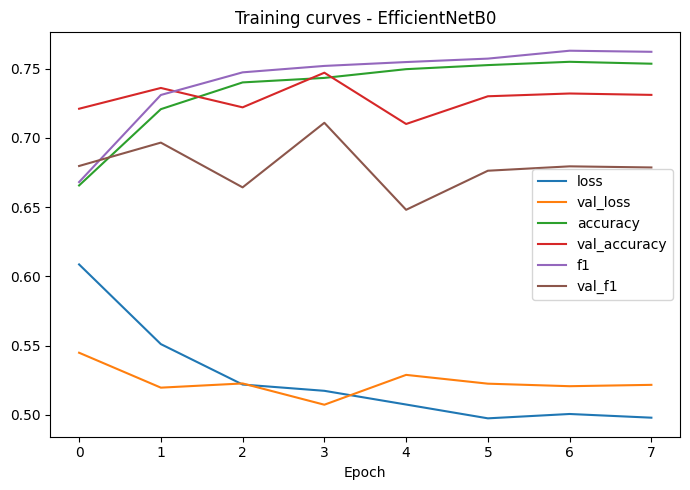

In [12]:
#Plot training curves (pre-FT)

def plot_history(history, keys=("loss","val_loss","accuracy","val_accuracy","f1","val_f1")):
    fig, ax = plt.subplots(figsize=(7,5))
    for k in keys:
        if k in history.history:
            ax.plot(history.history[k], label=k)
    ax.set_xlabel('Epoch')
    ax.set_title('Training curves - EfficientNetB0')
    ax.legend()
    fig.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, "training_curves_efficientnetb0.png")
    fig.savefig(out_path, dpi=160)
    print("Saved:", out_path)

plot_history(hist_eff)


This plot visualizes the model’s learning behavior during the frozen-stage training.
Key observations from the curves:

*   **Training loss decreases steadily**, confirming that the classifier layers are learning effectively.
*   **Training accuracy and F1 improve consistently** across epochs.
*   **Validation accuracy and F1 peak around epoch 4**, which matches the best checkpoint saved by EarlyStopping.
*   After epoch 4, **validation metrics fluctuate**, indicating the model reached its maximum capacity with the backbone frozen.
*   The validation loss curve confirms this pattern, showing mild instability beyond the optimal epoch.

Overall, the curves show a healthy training process with no signs of severe overfitting, and they justify moving to the next step: **fine-tuning the backbone.**






# 10.    Fine-Tuning Configuration
In this phase, the EfficientNetB0 backbone is partially unfrozen to allow deeper feature learning.
Only the last 120 layers of the network are set as trainable, while the earlier layers remain frozen to preserve the stable pretrained ImageNet features.

*   This selective unfreezing enables the model to focus on deepfake-specific patterns.
*   A lower learning rate (3e-5) is used to ensure stable and safe fine-tuning.
*   The model is then recompiled using the same loss and metrics.

This step prepares the model for the fine-tuning phase, where most of the performance improvement happens.


In [13]:
#Fine-tuning setup

base_eff.trainable = True

for layer in base_eff.layers[:-120]:
    layer.trainable = False

model_eff.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics_eff,
)

print("Fine-tune setup done.")


Fine-tune setup done.


# 11.    Fine-Tuning Training and Curves (EfficientNetB0)
In this step, we run the fine-tuning phase of the model, where the last 120 layers of EfficientNetB0 are now trainable with a lower learning rate.

*   The model is trained for **4 epochs** using the same training and validation pipelines and the same callbacks.
*   During this phase, **the validation F1-score jumps from about 0.71 (frozen stage) to ≈ 0.94**, and validation accuracy reaches around **93–94%.**
*   Validation loss also decreases noticeably, showing that the model is learning more discriminative features for deepfake detection.






Epoch 1/4
3998/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7913 - f1: 0.7826 - loss: 0.4310 - precision: 0.8168 - recall: 0.7533
Epoch 1: val_f1 improved from 0.71086 to 0.90020, saving model to /content/drive/MyDrive/deepdetect_effnet_outputs/best_efficientnetb0.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 217s 26ms/step - accuracy: 0.7914 - f1: 0.7827 - loss: 0.4309 - precision: 0.8169 - recall: 0.7533 - val_accuracy: 0.9000 - val_f1: 0.9002 - val_loss: 0.2392 - val_precision: 0.9396 - val_recall: 0.8640 - learning_rate: 3.0000e-05
Epoch 2/4
3999/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9205 - f1: 0.9194 - loss: 0.2032 - precision: 0.9165 - recall: 0.9225
Epoch 2: val_f1 improved from 0.90020 to 0.92233, saving model to /content/drive/MyDrive/deepdetect_effnet_outputs/best_efficientnetb0.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 86s 22ms/step - accuracy: 0.9205 - f1: 0.9194 - loss: 0.2032 - precision: 0.9165 - recall: 0.9225 - val_accuracy: 0.9200 - val_f1: 0.9223 - val_loss:

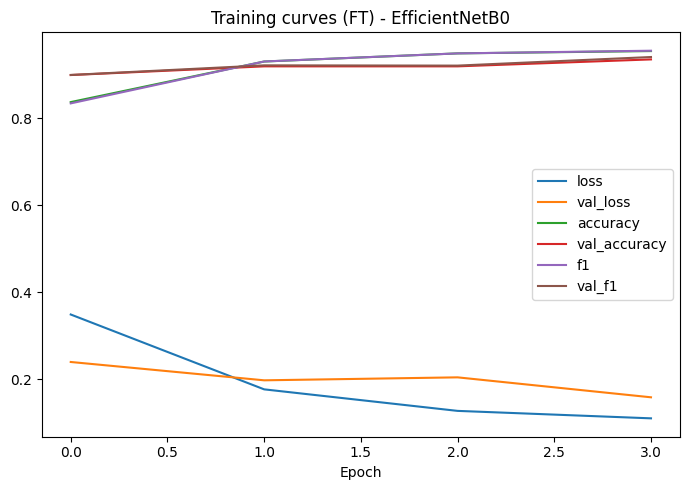

In [14]:
#Fine-tuning training run

hist_ft_eff = model_eff.fit(
    train_ds.repeat(),
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=4,
    callbacks=callbacks_eff,
    verbose=1,
)

def plot_history_ft(history, keys=("loss","val_loss","accuracy","val_accuracy","f1","val_f1")):
    fig, ax = plt.subplots(figsize=(7,5))
    for k in keys:
        if k in history.history:
            ax.plot(history.history[k], label=k)
    ax.set_xlabel('Epoch')
    ax.set_title('Training curves (FT) - EfficientNetB0')
    ax.legend()
    fig.tight_layout()
    out_path = os.path.join(OUTPUT_DIR, "training_curves_ft_efficientnetb0.png")
    fig.savefig(out_path, dpi=160)
    print("Saved:", out_path)

plot_history_ft(hist_ft_eff)


The fine-tuning curves show a clear and stable improvement across all performance metrics:

*   **Training and validation loss drop sharply**, indicating effective learning after unfreezing the deeper EfficientNet layers.
*   **Validation accuracy and validation F1-score rise to ~0.93–0.94**, showing a strong generalization improvement compared to the frozen stage.
*   The training and validation curves stay **very close**, with no divergence, meaning the model is not overfitting during fine-tuning.
*   The F1 score curve becomes smooth and steadily increases, confirming that the model is now correctly capturing deepfake-specific patterns.

Overall, this graph demonstrates that fine-tuning significantly boosts model performance and leads to a much more discriminative feature representation.



# 12.    Final Evaluation on Test Set and Saving Artifacts
In this final step, we evaluate the fine-tuned EfficientNetB0 model on the held-out test set, which contains images never seen during training or validation.

*   For each test batch, the model predicts a probability, which is converted to a binary label using a** 0.5 threshold.**
*   We then compute a detailed **classification report** (precision, recall, F1-score, and support) for the two classes: **Fake** and **Real**.
*   A **confusion matrix** is generated and visualized to show how many samples from each class were correctly and incorrectly classified.
In our runs, the model achieves around **0.89 accuracy** and F1-score, with balanced performance across both classes.

Finally, we save:

*   The **trained model** (final_model_efficientnetb0.keras)
*   A **JSON file** containing the main test metrics and the confusion matrix

These artifacts can be reused later for further analysis, deployment, or comparison with other architectures such as ResNet.



FINAL Test Report (EfficientNetB0):
              precision    recall  f1-score   support

        Fake     0.9008    0.8816    0.8911      5492
        Real     0.8825    0.9016    0.8919      5414

    accuracy                         0.8915     10906
   macro avg     0.8917    0.8916    0.8915     10906
weighted avg     0.8917    0.8915    0.8915     10906

Saved: /content/drive/MyDrive/deepdetect_effnet_outputs/confusion_matrix_efficientnetb0.png
Artifacts saved to: /content/drive/MyDrive/deepdetect_effnet_outputs


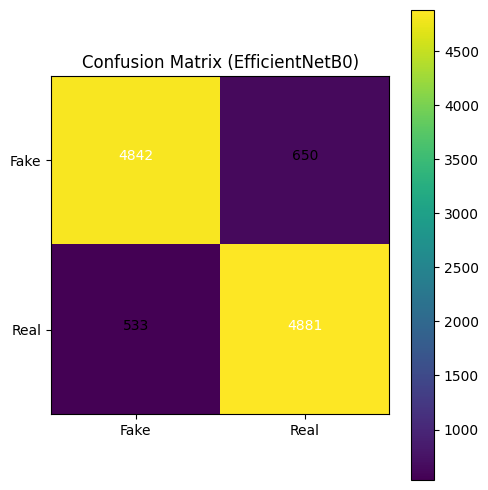

In [15]:
#Final evaluation on test set

y_true, y_pred = [], []

for images, labels in test_ds:
    probs = model_eff.predict(images, verbose=0).ravel()
    y_true.extend(labels.numpy().tolist())
    y_pred.extend((probs >= 0.5).astype(int).tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\nFINAL Test Report (EfficientNetB0):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix (EfficientNetB0)')
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

th = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center',
            color=('white' if cm[i, j] > th else 'black'),
        )

fig.colorbar(im)
fig.tight_layout()

cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix_efficientnetb0.png')
fig.savefig(cm_path, dpi=160)
print("Saved:", cm_path)


#Save model + metrics JSON

model_path = os.path.join(OUTPUT_DIR, 'final_model_efficientnetb0.keras')
model_eff.save(model_path)

metrics_json_path = os.path.join(OUTPUT_DIR, 'test_metrics_efficientnetb0.json')
with open(metrics_json_path, 'w') as f:
    json.dump(
        {
            'classes': class_names,
            'accuracy':  float(accuracy_score(y_true, y_pred)),
            'precision': float(precision_score(y_true, y_pred)),
            'recall':    float(recall_score(y_true, y_pred)),
            'f1':        float(f1_score(y_true, y_pred)),
            'confusion_matrix': cm.tolist(),
        },
        f,
        indent=2,
    )

print("Artifacts saved to:", OUTPUT_DIR)


# Sample Model Predictions (Real vs Fake)
Below are random prediction samples from the Test and Validation datasets. Each image is labeled as: Predicted : True
Green = Correct prediction
Red = Wrong prediction

In [10]:

# Load the best checkpoint (based on val_f1)
vis_model_path = os.path.join(OUTPUT_DIR, "best_efficientnetb0.keras")
model_vis = keras.models.load_model(vis_model_path, compile=False)

print("Visualization model loaded from:", vis_model_path)


Visualization model loaded from: /content/drive/MyDrive/deepdetect_effnet_outputs/best_efficientnetb0.keras


In [11]:
import math

# Normalize image to [0, 1] for display
try:
    _to_display_range
except NameError:
    def _to_display_range(img):
        img = np.array(img)
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[..., 0]
        img = img.astype("float32")
        return np.clip(img, 0.0, 1.0)

# Make sure predictions are proper probabilities
def _ensure_probs(pred):
    pred = np.array(pred)
    # Binary case: sigmoid output with shape (N, 1)
    if pred.ndim == 2 and pred.shape[1] == 1:
        p1 = pred[:, 0]
        return np.stack([1 - p1, p1], axis=1)
    # Multiclass: already in [N, num_classes]
    return pred


In [12]:
def display_predictions(dataset,
                        model,
                        class_names,
                        n=24,
                        cols=8,
                        title_mode="name",
                        save_png=False,
                        png_name="predictions_grid.png"):

    imgs, labs = [], []

    # Take n samples from the dataset
    for img, lab in dataset.unbatch().take(n):
        imgs.append(img.numpy())
        labs.append(lab.numpy())

    labs = np.array(labs)
    if labs.ndim > 1:   # one-hot case
        labs = labs.argmax(axis=-1)

    # Stack images and run model inference
    x = np.stack(imgs, axis=0)
    raw_pred = model.predict(x, verbose=0)
    probs = _ensure_probs(raw_pred)
    pred_idx = probs.argmax(axis=1)

    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * 2.2, rows * 2.2))

    for i in range(n):
        disp = _to_display_range(imgs[i])
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(disp, cmap="gray" if disp.ndim == 2 else None)

        correct = (pred_idx[i] == labs[i])

        if title_mode == "name":
            title = f"{class_names[pred_idx[i]]} : {class_names[labs[i]]}"
        else:
            title = f"pred={pred_idx[i]} / true={labs[i]}"

        ax.set_title(title,
                     color=("green" if correct else "red"),
                     fontsize=8)
        ax.axis("off")

    if save_png:
        out_path = os.path.join(OUTPUT_DIR, png_name)
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
        print("Saved predictions grid to:", out_path)

    plt.show()


**Display Sample Validation Results**

Saved predictions grid to: /content/drive/MyDrive/deepdetect_effnet_outputs/val_predictions_grid.png


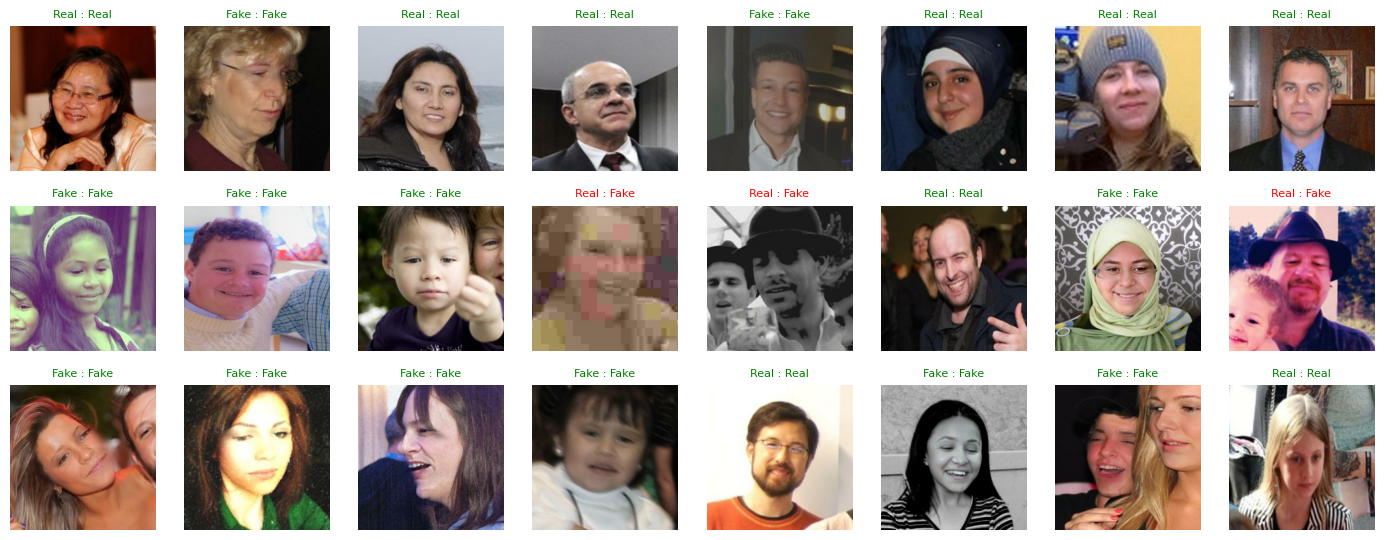

In [13]:
# Display Sample Validation Results
display_predictions(
    val_ds,
    model_vis,
    class_names=class_names,   # ['Fake', 'Real']
    n=24,
    cols=8,
    title_mode="name",
    save_png=True,
    png_name="val_predictions_grid.png",
)


**Display Sample Test Results**

Saved predictions grid to: /content/drive/MyDrive/deepdetect_effnet_outputs/test_predictions_grid.png


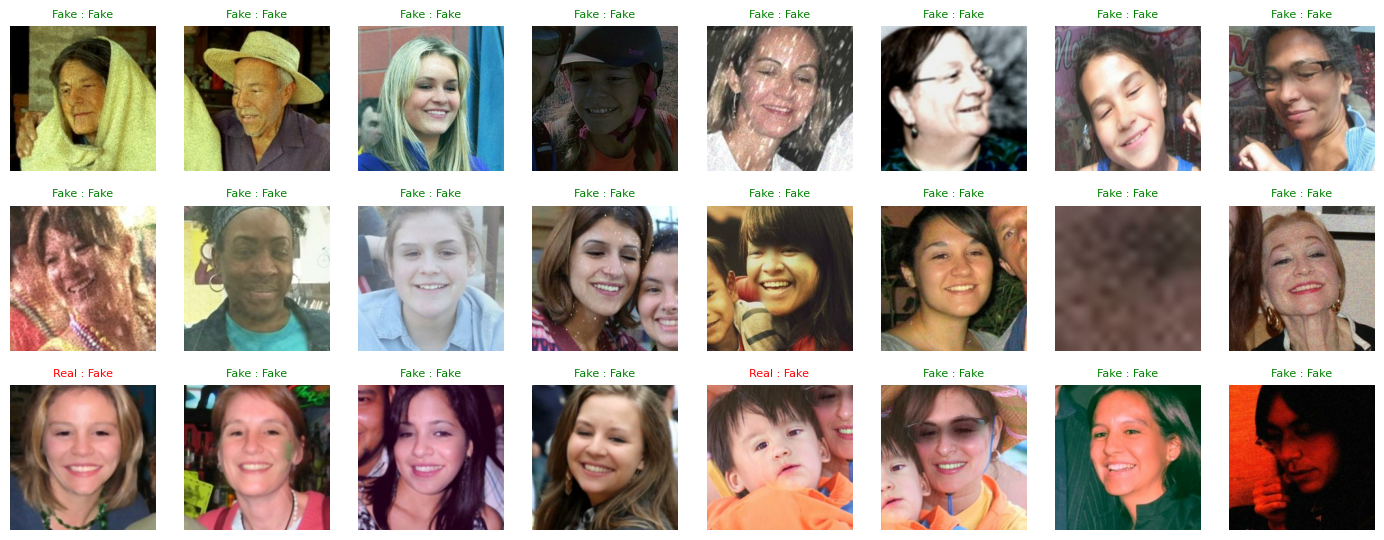

In [14]:
# Display Sample Test Results
display_predictions(
    test_ds,
    model_vis,
    class_names=class_names,
    n=24,
    cols=8,
    title_mode="name",
    save_png=True,
    png_name="test_predictions_grid.png",
)


# Final Test Performance Summary
The final evaluation on the unseen test set shows that the fine-tuned EfficientNetB0 achieves **strong and well-balanced performance** across both classes:

*   Overall accuracy: 0.8915
*   F1-score (Fake): 0.8911
*   F1-score (Real): 0.8919
*   The precision and recall values are balanced, indicating that the model is not biased toward one class.

The **confusion matrix** further confirms this balance:

*   The model correctly identified **4842 Fake** images and **4881 Real** images.
*   Misclassifications are relatively low (650 Fakes predicted as Real, 533 Reals predicted as Fake).
*   The diagonal dominance of the matrix (bright yellow squares) reflects strong classification ability.

Overall, the model demonstrates **high reliability and practical performance** in distinguishing between real and fake images, validating the effectiveness of EfficientNetB0 fine-tuning for deepfake detection.





